# **Variational Autoencoder (VAE) on MNIST dataset using CNN**

Import all necessary packets.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import random

Load MNIST data set and prepare it for training by normalization.

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Varaiational AutoEncoder model with fuly connected network

In [114]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# CNN
# network parameters
input_shape = (image_size, image_size, 1)
latent_dim = 2

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=16,kernel_size=3,activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=32,kernel_size=3,activation='relu', strides=2, padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(x)

outputs = Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 14, 14, 16)   160         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 7, 7, 32)     4640        conv2d_57[0][0]                  
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 1568)         0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
dense_73 (

Prepare customized loss function.

In [0]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')


Train the neural network.

In [116]:
vae.fit(x_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_test, None),
        verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 14s - loss: 203.2102 - val_loss: 174.6242
Epoch 2/100
 - 8s - loss: 171.3097 - val_loss: 168.4029
Epoch 3/100
 - 8s - loss: 166.7079 - val_loss: 164.4799
Epoch 4/100
 - 8s - loss: 164.1369 - val_loss: 166.6370
Epoch 5/100
 - 8s - loss: 162.2260 - val_loss: 161.8181
Epoch 6/100
 - 8s - loss: 160.7757 - val_loss: 161.9476
Epoch 7/100
 - 8s - loss: 159.5613 - val_loss: 159.0920
Epoch 8/100
 - 9s - loss: 158.5494 - val_loss: 157.6307
Epoch 9/100
 - 9s - loss: 157.6498 - val_loss: 157.1007
Epoch 10/100
 - 9s - loss: 156.8822 - val_loss: 158.2389
Epoch 11/100
 - 8s - loss: 156.2215 - val_loss: 156.1040
Epoch 12/100
 - 8s - loss: 155.6028 - val_loss: 154.7957
Epoch 13/100
 - 9s - loss: 154.9718 - val_loss: 154.9111
Epoch 14/100
 - 9s - loss: 154.4683 - val_loss: 155.4381
Epoch 15/100
 - 9s - loss: 154.0450 - val_loss: 153.2766
Epoch 16/100
 - 9s - loss: 153.5575 - val_loss: 155.2287
Epoch 17/100
 - 9s - loss: 153.1620 - val_loss

Visualizations

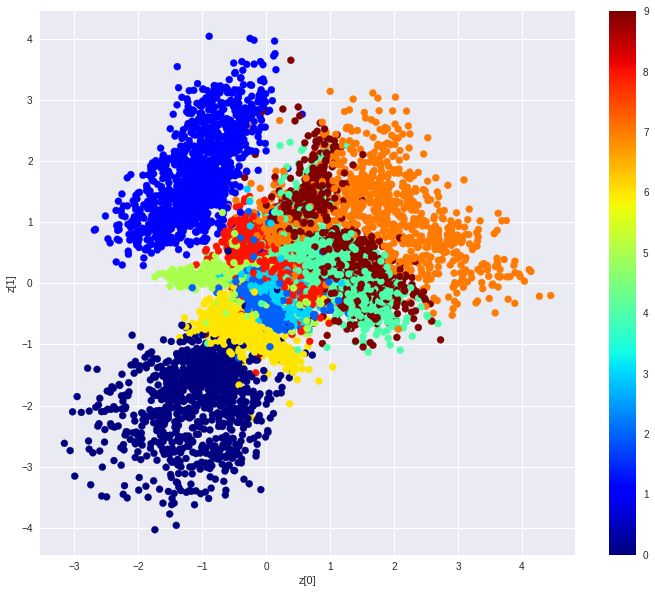

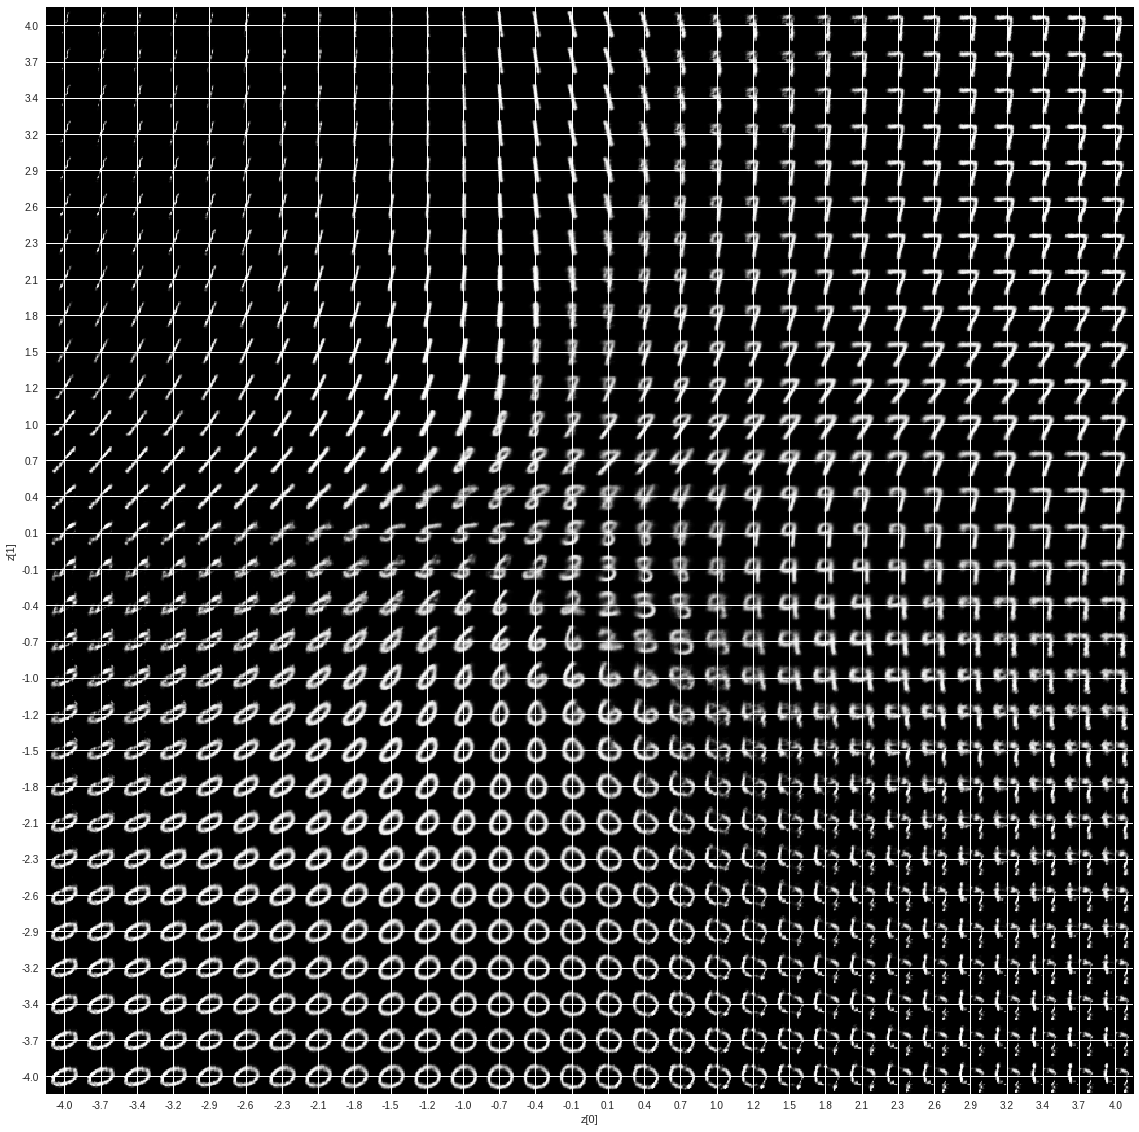

In [118]:
model_name="vae_mnist"
encoder, decoder = models
x_test, y_test = data
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

filename = os.path.join(model_name, "digits_over_latent.png")
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig(filename)
plt.show()

Images generated by VAE from random noise

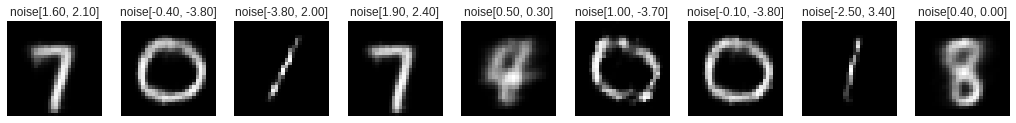

In [137]:
# Plot 10 examples when feeding the decoder with random samples from the 
# latent two-dimensional space
n = 10 
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # Generate a random sample with values between -4.0 and 4.0
    z_sample = np.array([[random.randint(-40,40)/10, random.randint(-40,40)/10]])
    # Feed decoder
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    
    # Plot one example
    ax = plt.subplot(1, n, i)
    plt.imshow(digit)
    plt.title("noise[%.2f, %.2f]" %(z_sample[0,0], z_sample[0,1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()